# 1 Softmax回归从零开始实现


In [1]:
import torch
from IPython import display
from d2l import torch as d2l
import torchvision
from matplotlib import pyplot as plt
from torchvision import  transforms
from torch.utils import data
batch_size = 256
# 把前面构建DataLoader放进一个函数，直接返回DataLoader
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=trans, download=True)
    
    return (data.DataLoader(dataset=mnist_train, batch_size=batch_size), data.DataLoader(dataset=mnist_test, batch_size=batch_size))

train_iter, test_iter = load_data_fashion_mnist(batch_size)

展平每个图片，将他们视为长度为784的向量（28*28）
我们数据集有10个类别，所以网络输出维度为10

对Softmax来说，输入需要是一个向量，所以要把28*28的图片拉成一个向量，拉成向量会损失很多空间信息，所以后面用卷积神经网络

In [2]:
num_inputs = 784
num_outputs = 10

# 随机初始化权重
w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

实现Softmax

$$
\text{softmax(X)}_{ij} = \frac{exp(X_{ij})}{ \sum_k exp(X_{ik})}
$$
对矩阵来说，是对每一行做Softmax

In [3]:
def softmax(X):
    x_exp = torch.exp(X) # 对每个元素做指数运算
    partition = x_exp.sum(dim=1, keepdim=True)
    return x_exp / partition # 第 i 行，每个元素都除以partition中第i个元素

In [4]:
a= torch.tensor([[1, 2], [3, 5]])
a.sum(dim=1,keepdim=True), a.sum(dim=1)

(tensor([[3],
         [8]]),
 tensor([3, 8]))

验证一下：我们将每个元素变成一个非负数。每行总和应该为1

In [5]:
X = torch.normal(0, 1, (2, 5)) # 标准正态分布，应该正负都有
X_prob = softmax(X) # 经过Softmax之后就会变成0~1之间的概率
X_prob, X_prob.sum(1, keepdim=True)

(tensor([[0.1966, 0.1174, 0.6050, 0.0543, 0.0268],
         [0.0156, 0.0207, 0.2327, 0.0972, 0.6338]]),
 tensor([[1.],
         [1.]]))

实现softmax 回归模型

In [6]:
def net(X):
    # 把X reshape成 （batch_size，784）
    return softmax(torch.matmul(X.reshape((-1, w.shape[0])), w) + b)
w.shape

torch.Size([784, 10])

例子

In [7]:
y = torch.tensor([0, 2]) # 共2个样本，真实label分别是0类，2类
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])

# 相当于y_hat[[0,1], [0, 2]]，第一个[0, 1]表示y_hat的第0个和第1个样本，分别是[0.1, 0.3, 0.6]，[0.3, 0.2, 0.5]。
# 我们对y_hat的第0个样本和第1个样本分别取出第[0,2]个元素，即0.1和0.5

y_hat[[0,1], y] # 获取样本真实类别的预测概率，例如第0个样本真实label是0，那么0预测的概率是0.1。第1个样本真实label是2,预测为2的概率为0.5

tensor([0.1000, 0.5000])

实现交叉熵损失函数

In [8]:
def cross_entropy(y_hat, y):
    # y_hat[range(len(y_hat)),y]# 获取真实值对应的预测概率。 之后再求log，再取负数
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y), y_hat[range(len(y_hat)),y]# 获取真实值对应的预测概率

(tensor([2.3026, 0.6931]), tensor([0.1000, 0.5000]))

In [9]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] >1: # 如果是个二维矩阵
        y_hat = y_hat.argmax(axis=1) # 获取预测的类别 axis=1是一行里面所有列相互操作
    cmp = y_hat.type(y.dtype) == y  # y_hat.type(y.dtype)将y_hat的数据类型转为y的数据类型
    return float(cmp.type(y.dtype).sum()) # 预测正确的样本数量，而不是准确率

accuracy(y_hat, y) / len(y)

0.5

评估在任意模型net的准确率

In [10]:
def evaluate_accuracy(net, data_iter):
    ''' 计算在指定数据集上模型的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为eval模式，不计算梯度
    metric = Accumulator(2) # 正确预测数，预测总数  
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())  # 不断的将预测正确的和预测的总数加入到累加器中，累加器就是用于统计整个数据集上的预测正确的总数，和预测的样本数量
    return metric[0] / metric[1] # 分类正确的样本数 除以 样本总数

In [11]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, index):
        return self.data[index]
    
evaluate_accuracy(net, test_iter)        

0.131

Softmax回归的训练

In [12]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel()) # 为什么y.size()? y.size().numel()
        else:
            l.sum().backward()
            updater(X.shape[0]) # X.shape[0] 批量大小
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]  # metric[0]: 所有loss的累加。metric[1]: 分类正确的样本数。metric[2]: 样本总数

定义一个在动画中绘制数据的使用程序类

In [13]:
class Animator:  
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        # plt.draw(); plt.pause(0.1)
        display.clear_output(wait=True)

训练函数

In [14]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

小批量随机梯度下降来优化模型的损失函数

In [15]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

训练模型

In [16]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

预测

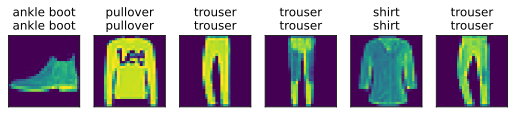

In [17]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break # 只取一个batch
    
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true+'\n' + preds for true, preds in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles[0:n])
predict_ch3(net, test_iter)

# Softmax简洁实现

In [19]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [21]:
# flatten将任意维度展开成二维，第0维度保留，剩下的所有展成一个向量
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01) # 如果是一个nn.Linear就将m的weight初始化成一个方差是0.01，均值为0，符合正态分布的随机值
net.apply(init_weights) # net每一层跑一下这个初始化权重的函数

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

交叉熵

In [22]:
loss = nn.CrossEntropyLoss()

优化算法

In [23]:
optimizer= torch.optim.SGD(net.parameters(), lr=0.1)

定义训练函数

In [24]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)